In [1]:
# 1. Import Libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

print(f"TensorFlow Version: {tf.__version__}")

# --- Configuration ---
RANDOM_STATE = 42  # for reproducibility
TEST_SIZE = 0.3    # 30% of data for testing
EPOCHS = 100       # Number of training iterations
BATCH_SIZE = 8     # Number of samples per gradient update









TensorFlow Version: 2.18.0


In [2]:
# 2. Load and Prepare Data
print("\n--- Loading and Preparing Data ---")
# Load dataset
iris = load_iris()
X = iris.data  # Features (sepal length/width, petal length/width)
y = iris.target # Target labels (0, 1, 2 for Setosa, Versicolor, Virginica)
feature_names = iris.feature_names
target_names = iris.target_names

print(f"Dataset shape: Features {X.shape}, Target {y.shape}")
print(f"Feature names: {feature_names}")
print(f"Target names: {target_names}")
print(f"Unique target labels: {np.unique(y)}")


--- Loading and Preparing Data ---
Dataset shape: Features (150, 4), Target (150,)
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']
Unique target labels: [0 1 2]


In [3]:

# One-Hot Encode the target variable 'y'
# Reshape y to be a 2D array for the encoder
y_reshaped = y.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y_reshaped)
print(f"Shape of one-hot encoded y: {y_encoded.shape}")
# Example: Label 0 -> [1., 0., 0.], Label 1 -> [0., 1., 0.], Label 2 -> [0., 0., 1.]
print(f"Example encoded labels:\n{y_encoded[:5]}")

Shape of one-hot encoded y: (150, 3)
Example encoded labels:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [4]:

# Split data into training and testing sets
# Stratify ensures proportional representation of classes in train/test splits
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print(f"Training set shapes: X={X_train.shape}, y={y_train_encoded.shape}")
print(f"Testing set shapes:  X={X_test.shape}, y={y_test_encoded.shape}")


Training set shapes: X=(105, 4), y=(105, 3)
Testing set shapes:  X=(45, 4), y=(45, 3)


In [5]:

# Scale the features (important for neural networks)
# Use StandardScaler: transforms data to have mean=0 and variance=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use the SAME scaler fitted on training data


In [6]:

# 3. Define the Model Architecture
print("\n--- Defining the Model Architecture ---")
input_dim = X_train_scaled.shape[1]  # Number of features (4 for Iris)
output_dim = y_encoded.shape[1]   # Number of classes (3 for Iris)

# Using Keras Sequential API for a simple stack of layers
model = keras.Sequential(
    [
        # Input Layer: Implicitly defined by input_shape in the first Dense layer
        # Hidden Layer 1: Dense (fully connected), 8 neurons, ReLU activation
        layers.Dense(8, activation="relu", input_shape=(input_dim,), name="hidden_layer_1"),
        # Hidden Layer 2: Dense, 8 neurons, ReLU activation
        layers.Dense(8, activation="relu", name="hidden_layer_2"),
        # Output Layer: Dense, number of neurons = number of classes, Softmax activation
        # Softmax ensures output probabilities sum to 1, suitable for multi-class classification
        layers.Dense(output_dim, activation="softmax", name="output_layer"),
    ],
    name="iris_classifier",
)

# Display model summary
model.summary()


--- Defining the Model Architecture ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "iris_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139 (556.00 B)

 Trainable params: 139 (556.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:

# 4. Compile the Model
print("\n--- Compiling the Model ---")
# Optimizer: Adam is a common and effective choice
# Loss Function: 'categorical_crossentropy' is used for multi-class classification
#              with one-hot encoded labels.
# Metrics: 'accuracy' is a straightforward metric to monitor during training.
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
print("Model compiled successfully.")



--- Compiling the Model ---
Model compiled successfully.


In [8]:

# 5. Train the Model
print("\n--- Training the Model ---")
# We train the model using the scaled training data
# 'validation_data' allows monitoring performance on the test set during training
# 'history' object stores training metrics for each epoch
history = model.fit(
    X_train_scaled,
    y_train_encoded,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_scaled, y_test_encoded),
    verbose=1,  # Set to 0 to hide epoch progress, 1 for progress bar, 2 for one line per epoch
)
print("Model training complete.")



--- Training the Model ---
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.3107 - loss: 1.0797 - val_accuracy: 0.3556 - val_loss: 1.0570
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3433 - loss: 1.0247 - val_accuracy: 0.3778 - val_loss: 1.0143
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3963 - loss: 0.9704 - val_accuracy: 0.4000 - val_loss: 0.9728
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4741 - loss: 0.9416 - val_accuracy: 0.4444 - val_loss: 0.9403
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5014 - loss: 0.8996 - val_accuracy: 0.5111 - val_loss: 0.9081
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4948 - loss: 0.8968 - val_accuracy: 0.5778 - val_loss: 0.8741
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5478 - loss: 0.8433 - val_accuracy: 0.6222 - val_loss: 0.8389
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5980 - los


--- Evaluating the Model ---
Test Set Loss:     0.1352
Test Set Accuracy: 0.9111 (91.11%)

--- Plotting Training History ---


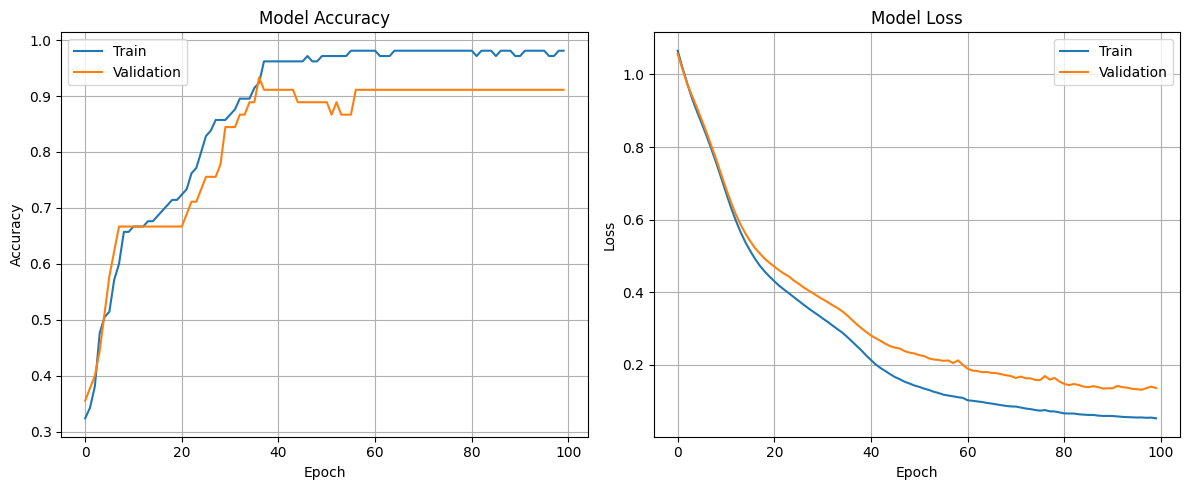

In [9]:

# 6. Evaluate the Model
print("\n--- Evaluating the Model ---")
# Evaluate the trained model on the scaled test data
loss, accuracy = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"Test Set Loss:     {loss:.4f}")
print(f"Test Set Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# --- Plotting Training History (Optional) ---
print("\n--- Plotting Training History ---")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.grid(True)

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [10]:

# 7. Make Predictions and Detailed Evaluation
print("\n--- Making Predictions and Detailed Evaluation ---")
# Predict probabilities for the test set
predictions_prob = model.predict(X_test_scaled)

# Convert probabilities to class labels (index of the highest probability)
predictions_class = np.argmax(predictions_prob, axis=1)

# Convert one-hot encoded test labels back to original class labels for comparison
y_test_original = np.argmax(y_test_encoded, axis=1)

# Print Classification Report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test_original, predictions_class, target_names=target_names))

# Print Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_original, predictions_class)
print(cm)


--- Making Predictions and Detailed Evaluation ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45


Confusion Matrix:
[[15  0  0]
 [ 0 14  1]
 [ 0  3 12]]


In [11]:

# Example: Predict on a single new sample (needs scaling)
# Let's take the first sample from the original *unscaled* test set for demonstration
# In a real scenario, this would be new, unseen data
new_sample = X_test[0].reshape(1, -1) # Reshape for scaler and model
# MUST scale the new sample using the SAME scaler fitted on the training data
new_sample_scaled = scaler.transform(new_sample)

prediction_new_prob = model.predict(new_sample_scaled)
prediction_new_class_index = np.argmax(prediction_new_prob, axis=1)[0]
prediction_new_class_name = target_names[prediction_new_class_index]
print(f"\nExample Prediction on a new sample (scaled):")
print(f"  Features (original): {new_sample[0]}")
print(f"  Predicted Probabilities: {prediction_new_prob[0]}")
print(f"  Predicted Class Index: {prediction_new_class_index}")
print(f"  Predicted Class Name: {prediction_new_class_name}")
print(f"  Actual Class Index: {y_test_original[0]}")
print(f"  Actual Class Name: {target_names[y_test_original[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Example Prediction on a new sample (scaled):
  Features (original): [7.3 2.9 6.3 1.8]
  Predicted Probabilities: [6.5990616e-06 1.0866767e-02 9.8912662e-01]
  Predicted Class Index: 2
  Predicted Class Name: virginica
  Actual Class Index: 2
  Actual Class Name: virginica
